# Mechanical Ventilation in an Intensive Care Unit

- available at: <https://www.math.uwaterloo.ca/~rjcook/cook-lawless-multistate_data.html>
- used in `cook2018multistate`

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import collections
import matplotlib.pyplot as plt
import numpy as np

from mixmarkov import (
    CTMC,
    FiniteMixCTMC,
    GamMixCTMC,
    MGamMixCTMC,
    summarize_sequences,
)
from mixmarkov.baselines import CTRNN, seqs_to_tensor
from mixmarkov.utils import draw_chain

## Loading the data

- `id`: identifier of patient
- `age`: age (in years)
- `sex.female`: 0 if male, 1 if female
- `enum`: enumerates lines for a given patient
- `from`: source state
- `to`: destination state
- `estart`: beginning of at-risk period
- `estop`: end of at-risk period

states:

- 1: ventilation off
- 2: ventilation on
- 3: discharge from ICU
- 4: death

999 is used for right-censoring.

In [2]:
seqs = list()

with open("../data/ventICU.dat") as f:
    next(f)  # First line is header.
    cur = None
    for line in f:
        idx, age, sex, _, src, dst, estart, estop = line.strip().split(" ")
        src = int(src) - 1
        dst = int(dst) - 1
        if idx != cur:
            if cur is not None:
                seqs.append(seq)
            seq = list()
            cur = idx
            seq.append((src, float(estart)))
        if dst == 999 - 1:
            dst = src
        seq.append((dst, float(estop)))
    seqs.append(seq)
    
# Shuffle the sequences.
rng = np.random.default_rng(seed=0)
idx = rng.permutation(len(seqs))
seqs = np.array(seqs, dtype=object)[idx]

# states: 4
# sequences: 747
# edges: 6


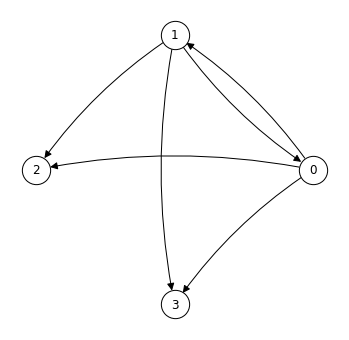

In [3]:
n = 4
ks, _ = summarize_sequences(seqs, n)
mask = np.sum(ks, axis=0).astype(bool)
np.fill_diagonal(mask, False)  # Remove self-transitions

print(f"# states: {n:,}")
print(f"# sequences: {len(seqs):,}")
print(f"# edges: {mask.sum():,}")

draw_chain(mask)

## Final evaluation

In [4]:
model1 = CTMC(mask)
model2 = MGamMixCTMC(mask)
model3 = GamMixCTMC(mask)

n_splits = 10
zs = np.linspace(0, len(seqs), num=(n_splits + 1), dtype=int)

res1 = np.zeros(n_splits)
res2 = np.zeros(n_splits)
res3 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    ks_train, ts_train = summarize_sequences(train, n)
    ks_valid, ts_valid = summarize_sequences(valid, n)
    # CTMC
    model1.fit(ks_train, ts_train)
    res1[i] = model1.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
    # MGamMixCTMC
    model2.fit(ks_train, ts_train)
    res2[i] = model2.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
    # GamMixCTMC
    model3.fit(ks_train, ts_train)
    res3[i] = model3.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)

Optimization terminated successfully.
         Current function value: 3855.494756
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 13
Optimization terminated successfully.
         Current function value: 4090.313417
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
         Hessian evaluations: 15
         Current function value: 3839.053182
         Iterations: 32
         Function evaluations: 57
         Gradient evaluations: 48
         Hessian evaluations: 33
Optimization terminated successfully.
         Current function value: 3876.503330
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 13
Optimization terminated successfully.
         Current function value: 4106.193388
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
         Hessian evaluations: 1

In [5]:
print("CTMC:          {:.3f} (std: {:.3f})".format(np.mean(res1), np.std(res1)))
print("MGamMixCTMC:   {:.3f} (std: {:.3f})".format(np.mean(res2), np.std(res2)))
print("GamMixCTMC:    {:.3f} (std: {:.3f})".format(np.mean(res3), np.std(res3)))

CTMC:          -5.764 (std: 0.442)
MGamMixCTMC:   -6.111 (std: 0.465)
GamMixCTMC:    -5.737 (std: 0.450)


### Finite Mixture

Selecting the number of finite mixture components:

- $L = 2$: -5.739 (averaged over 10 seeds)
- $L = 5$: -5.739 (averaged over 10 seeds)
- $L = 10$: -5.738 (averaged over 10 seeds)

In [6]:
n_seeds = 10
n_comps = 10

model5 = FiniteMixCTMC(mask, n_comps=n_comps)
res5 = np.zeros((n_seeds, n_splits))

for seed in range(n_seeds):
    for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
        train = np.concatenate((seqs[:z1], seqs[z2:]))
        valid = seqs[z1:z2]
        ks_train, ts_train = summarize_sequences(train, n)
        ks_valid, ts_valid = summarize_sequences(valid, n)
        model5.fit(ks_train, ts_train, seed=seed, verbose=False)
        res5[seed,i] = model5.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
        print(".", end="", flush=True)
    print()

..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


In [7]:
print("FiniteMixCTMC: {:.3f} (std: {:.3f})".format(np.mean(res5), np.std(np.mean(res5, axis=1))))

FiniteMixCTMC: -5.738 (std: 0.002)


### RNN

In [9]:
%%time
res6 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    print(".", end="", flush=True)
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    tensor_train = seqs_to_tensor(train, n)
    tensor_valid = seqs_to_tensor(valid, n)
    # RNN
    model6 = CTRNN(n, hidden_size=10)
    # Starts overfitting after 500 iterations.
    model6.fit(tensor_train, lr=0.1, n_iters=500, verbose=False)
    res6[i] = model6.predictive_loglike(tensor_valid) / len(tensor_valid)
    
print()

..........
CPU times: user 37min 35s, sys: 0 ns, total: 37min 35s
Wall time: 37min 4s


In [11]:
print("RNN: {:.3f} (std: {:.3f})".format(np.mean(res6), np.std(res6)))

RNN: -5.767 (std: 0.440)
